# Project 3: Web APIs & Classification

## Problem Statement

I work as an IT consultant who has a project with Reddit. The problem that Reddit found is the similar movies named 9-1-1 and NCIS have subreddit, but some users do not know the name of the subreddit that make them cannot post the new post or create the post in the wrong subreddit. Therefore, Reddit wants to try a model to collect the post from the user and select the subreddit for the user and increase more efficiency to manage the wrong post in subreddits.

### Contents:
- [Background](#Background)
- [Data collection](#Data-collection)
- [Data cleaning](#Data-cleaning)
- [Pre processing](#Pre-processing)
- [Concatenate](#Concatenate)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Trian Test Split](#Trian-Test-Split)
- [Model Preparation](#Model-Preparation)
- [Model Fitting](#Fit-the-model)
- [Model Evaluation](#Model-Evaluation)
- [Look for common words](#Look-for-common-words)
- [Finding the important word](#Finding-the-important-word)
- [Predict the subreddit when user make a post](#Predict-the-subreddit-when-user-make-a-post)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Background

**Reddit**

Reddit is the website for thousands of communication, conversation and human connection. There have many interesting communities such as sports, TV fan theories and news ([*source*](https://www.redditinc.com)).

**9-1-1**

The series explores the high-pressure experiences of first responders, including police officers, firefighters and dispatchers. These emergency responders must try to balance saving those who are at their most vulnerable with solving the problems in their own lives. The show is an action drama and draws from real-life, high-pressure experiences of first responders who regularly face heart-stopping situations that are often unpredictable, intense and uplifting at the same time ([*source*](https://www.fox.com/9-1-1/)).  

**NCIS (Naval Criminal Investigative Service)**

The series is an action drama and shows the focusing on the sometimes complex and always amusing dynamics of a team forced to work together in high-stress situations. A team in this series is special agents from the Naval Criminal Investigative Service in Washington, D.C. Their job is to investigate crimes involving the US Navy and Marine Corps. ([*source*](https://www.cbs.com/shows/ncis/about/))

In [1]:
# import the important libraries

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import seaborn as sns
import regex as re

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

## Data collection

- For the 911FOX subreddit, the post are extracted by the function named 'extract_post' and all posts are exported in csv file named '911FOX.csv'.
- For the NCIS subreddit, the post are extracted by the function named 'extract_post' and all posts are exported in csv file named 'ncis.csv'.

In [2]:
def extract_post(subreddit, loop = 40):
    
    """This function extracts the post from subreddit 40 times.
    
    Parameter
    ---------
    subreddit = name of subreddit
    """
    
    posts = []
    after = None
    url = f'https://www.reddit.com/r/{subreddit}.json'
    
    for a in range(loop):
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after
        print(current_url)
        res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})
    
        if res.status_code != 200:
            print('Status error', res.status_code)
            break
    
        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        after = current_dict['data']['after']

        # generate a random sleep duration to look more 'natural'
        sleep_duration = random.randint(2,60)
        print(sleep_duration)
        time.sleep(sleep_duration)
    return pd.DataFrame(posts)

In [3]:
# This code will take time to run so I make it as a comment. 
# I attach the picture of the result from running this code.

# fox = extract_post('911FOX')

<img src="images/fox01.png" alt="drawing" width="900"/>
<img src="images/fox02.png" alt="drawing" width="900"/>
<img src="images/fox03.png" alt="drawing" width="900"/>

In [4]:
# export all posts into .csv file

# fox.to_csv('911FOX.csv', index = False)

In [5]:
# import data from the .csv file

fox_df = pd.read_csv('datasets/911FOX.csv')

In [6]:
fox_df.head()

,approved_at_utc,subreddit,selftext,user_reports,saved,mod_reason_title,gilded,clicked,title,event_start,...,is_video,crosspost_parent_list,url_overridden_by_dest,crosspost_parent,link_flair_template_id,is_gallery,media_metadata,gallery_data,poll_data,author_cakeday
0,NaN,911FOX,"Airdate: Sunday, January 19, 2020\n\nSynopsis:...",[],False,NaN,0,False,"9-1-1: Lone Star | S01E01 ""Pilot"" [Live Series...",1.579488e+09,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,911FOX,The 118 are called to the tarmac when a flight...,[],False,NaN,0,False,"9-1-1 | S04E08 ""Breaking Point"" [Live Episode ...",1.615251e+09,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,911FOX,NaN,[],False,NaN,0,False,Hey this looks familiar...,NaN,...,False,"[{'approved_at_utc': None, 'subreddit': 'Whatc...",https://v.redd.it/dg15lvy9lhn61,t3_m6o68h,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,911FOX,why is 9-1-1 doing a six week break? It seems ...,[],False,NaN,0,False,hiatus,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,911FOX,"As we all know, Fox is re-airing all the Begin...",[],False,NaN,0,False,Eddie Diaz (Ryan Guzman) and his fans,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# This code will take time to run so I make it as a comment. 
# I attach the picture of the result from running this code.

# ncis = extract_post('NCIS')

<img src="images/ncis01.png" alt="drawing" width="900"/>
<img src="images/ncis02.png" alt="drawing" width="900"/>
<img src="images/ncis03.png" alt="drawing" width="900"/>

In [8]:
# export all posts into .csv file

# ncis.to_csv('ncis.csv', index = False)

In [9]:
# import data from the .csv file

ncis_df = pd.read_csv('datasets/ncis.csv')

In [10]:
ncis_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,post_hint,url_overridden_by_dest,preview,is_gallery,media_metadata,gallery_data,poll_data,author_cakeday,crosspost_parent_list,crosspost_parent
0,NaN,NCIS,"When a petty officer is shot down by a sniper,...",t2_6nbav,False,NaN,0,False,NCIS: New Orleans 7 x 10 - Homeward Bound - Ep...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NCIS,"The team uncovers a secret dogfighting ring, w...",t2_6nbav,False,NaN,0,False,NCIS 18 x 10- Watchdog - Episode Discussion,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NCIS,"Abby: his system was completely clean, it’s as...",t2_3kbqbvzf,False,NaN,0,False,Jimmy Palmer - timeless wit,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NCIS,NaN,t2_13843vsh,False,NaN,0,False,This was the first episode I was cheering for ...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NCIS,**SPOILERS**\n\nARE YOU KIDDING ME?!? If this ...,t2_93de27wo,False,NaN,0,False,Leroy Jethro Gibbs **spoilers**,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning

In [11]:
# Check missing value

missing_fox = pd.DataFrame(fox_df.isnull().sum().sort_values(ascending = False), columns = ['fox_missing_values'])
missing_fox_count = missing_fox[missing_fox['fox_missing_values'] >= 1]
missing_fox_count

,fox_missing_values
approved_at_utc,1000
likes,1000
link_flair_background_color,1000
removal_reason,1000
mod_reason_by,1000
num_reports,1000
removed_by,1000
view_count,1000
banned_at_utc,1000
suggested_sort,1000


In [12]:
# Check missing value

missing_ncis = pd.DataFrame(ncis_df.isnull().sum().sort_values(ascending = False), columns = ['ncis_missing_values'])
missing_ncis_count = missing_ncis[missing_ncis['ncis_missing_values'] >= 1]
missing_ncis_count

,ncis_missing_values
approved_at_utc,996
removed_by_category,996
link_flair_background_color,996
removal_reason,996
mod_reason_by,996
num_reports,996
removed_by,996
view_count,996
banned_at_utc,996
suggested_sort,996


In [13]:
def clean_data(data):
    
    """This function creates a new dataframe which contains text and subreddit.
    The missing value in 'selftext' column are filled by ''.
    The new dataframe has 2 columns ('alltext' and 'subreddit')
    The 'alltext' column is from the combination between 'selftext' and 'title'.
    The new dataframe has the duplicate row so it needs to be drop by this function.
    
    Parameter
    ----------
    data = dataframe that you want to clean data
    """
    
    data['selftext'] = data['selftext'].fillna('')
    data['alltext'] = data['selftext'] + data['title']
    data.drop_duplicates(subset = 'name', inplace = True)
    data.reset_index(drop=True)
    data_text = data[['alltext', 'subreddit']]
    return data_text

In [14]:
fox_text = clean_data(fox_df)
fox_text.head()

,alltext,subreddit
0,"Airdate: Sunday, January 19, 2020\n\nSynopsis:...",911FOX
1,The 118 are called to the tarmac when a flight...,911FOX
2,Hey this looks familiar...,911FOX
3,why is 9-1-1 doing a six week break? It seems ...,911FOX
4,"As we all know, Fox is re-airing all the Begin...",911FOX


In [15]:
# 'fox_text' has 923 rows and 2 columns

fox_text.shape

(923, 2)

In [16]:
ncis_text = clean_data(ncis_df)
ncis_text.head()

,alltext,subreddit
0,"When a petty officer is shot down by a sniper,...",NCIS
1,"The team uncovers a secret dogfighting ring, w...",NCIS
2,"Abby: his system was completely clean, it’s as...",NCIS
3,This was the first episode I was cheering for ...,NCIS
4,**SPOILERS**\n\nARE YOU KIDDING ME?!? If this ...,NCIS


In [17]:
# 'ncis_text' has 996 rows and 2 columns

ncis_text.shape

(996, 2)

In [18]:
# Recheck missing value

fox_text.isnull().sum()

alltext      0
subreddit    0
dtype: int64

In [19]:
# Check the information of the dataframe

fox_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 922
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   alltext    923 non-null    object
 1   subreddit  923 non-null    object
dtypes: object(2)
memory usage: 21.6+ KB


In [20]:
# Recheck missing value

ncis_text.isnull().sum()

alltext      0
subreddit    0
dtype: int64

In [21]:
# Check the information of the dataframe

ncis_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996 entries, 0 to 995
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   alltext    996 non-null    object
 1   subreddit  996 non-null    object
dtypes: object(2)
memory usage: 23.3+ KB


After using the 'clean_data' function, the data frame of '911FOX' (fox_text) has 923 rows with 2 columns and the data frame of 'NCIS' (ncis_text) has 996 rows with 2 columns. Both data frames do not have any missing value and the type of value in all columns are the object.

## Pre-processing

In [22]:
def pre_processing(data):
    
    """This function uses for pre processing step.
    1. Remove non-letter
    2. Convert all letter to be lower letter
    3. Split string into list
    4. Remove stopwords: stopwords from 'stopwords.words('english')' combined with the specific words which stored
    in 'new_stopwords'
    5. Lemmatizer
    6. Join string
    
    Parameter
    ----------
    data = dataframe
    
    """
    
    #Remove non-letter
    data['alltext'] = data['alltext'].str.replace('[^A-Za-z]+',' ')
    
    #Change to lower letters
    data['alltext'] = data['alltext'].map(lambda x : x.lower())
    
    #Split string
    data['alltext'] = data['alltext'].map(lambda x : x.split())
    
    #Remove stopwords
    nltk.download('stopwords')
    new_stopwords = ['episode', 'show', 'season', '911fox', '911', 'ncis', 'cis', 'http', 'www']
    stop_words = (stopwords.words('english'))+(new_stopwords)
    data['no_stopword'] = data['alltext'].map(lambda x : [w for w in x if w not in stop_words])
    
    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    data['lemmatized'] = data['no_stopword'].map(lambda x : [lemmatizer.lemmatize(word) for word in x])
    
    #join string
    data['cleaned'] = data['lemmatized'].map(lambda x : (" ".join(x)))
    
    return data

In [23]:
fox_text = pre_processing(fox_text)
fox_text.head()

<ipython-input-22-5b7ac0371614>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['alltext'] = data['alltext'].str.replace('[^A-Za-z]+',' ')
<ipython-input-22-5b7ac0371614>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['alltext'] = data['alltext'].map(lambda x : x.lower())
<ipython-input-22-5b7ac0371614>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,alltext,subreddit,no_stopword,lemmatized,cleaned
0,"[airdate, sunday, january, synopsis, when, tra...",911FOX,"[airdate, sunday, january, synopsis, tragedy, ...","[airdate, sunday, january, synopsis, tragedy, ...",airdate sunday january synopsis tragedy strike...
1,"[the, are, called, to, the, tarmac, when, a, f...",911FOX,"[called, tarmac, flight, attendant, reaches, l...","[called, tarmac, flight, attendant, reach, lim...",called tarmac flight attendant reach limit fli...
2,"[hey, this, looks, familiar]",911FOX,"[hey, looks, familiar]","[hey, look, familiar]",hey look familiar
3,"[why, is, doing, a, six, week, break, it, seem...",911FOX,"[six, week, break, seems, sooo, long, wondered...","[six, week, break, seems, sooo, long, wondered...",six week break seems sooo long wondered anyone...
4,"[as, we, all, know, fox, is, re, airing, all, ...",911FOX,"[know, fox, airing, begins, hiatus, except, ed...","[know, fox, airing, begin, hiatus, except, edd...",know fox airing begin hiatus except eddie fan ...


In [24]:
ncis_text = pre_processing(ncis_text)
ncis_text.head()

<ipython-input-22-5b7ac0371614>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['alltext'] = data['alltext'].str.replace('[^A-Za-z]+',' ')
<ipython-input-22-5b7ac0371614>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['alltext'] = data['alltext'].map(lambda x : x.lower())
<ipython-input-22-5b7ac0371614>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

,alltext,subreddit,no_stopword,lemmatized,cleaned
0,"[when, a, petty, officer, is, shot, down, by, ...",NCIS,"[petty, officer, shot, sniper, pride, hunt, ki...","[petty, officer, shot, sniper, pride, hunt, ki...",petty officer shot sniper pride hunt killer fi...
1,"[the, team, uncovers, a, secret, dogfighting, ...",NCIS,"[team, uncovers, secret, dogfighting, ring, le...","[team, uncovers, secret, dogfighting, ring, le...",team uncovers secret dogfighting ring lead une...
2,"[abby, his, system, was, completely, clean, it...",NCIS,"[abby, system, completely, clean, rolled, gian...","[abby, system, completely, clean, rolled, gian...",abby system completely clean rolled giant pile...
3,"[this, was, the, first, episode, i, was, cheer...",NCIS,"[first, cheering, group, kill, dog, abusing, s...","[first, cheering, group, kill, dog, abusing, s...",first cheering group kill dog abusing son bitch
4,"[spoilers, are, you, kidding, me, if, this, is...",NCIS,"[spoilers, kidding, write, gibbs, done, underw...","[spoiler, kidding, write, gibbs, done, underwh...",spoiler kidding write gibbs done underwhelming...


**The role for each column**

Both 'fox_text' and 'ncis_text' dataframes have 5 columns.
- 'alltext' : The list of words after removing non-letter, converting to lower latter and splitting.
- 'subreddit' : The name of the subreddit
- 'no_stopword' : The list of words after removing stopwords
- 'lemmatized' : The list of words after lemmatizer
- 'cleaned' : The string of words after all pre-processing

## Concatenate

I use pd.concat() to combine 'fox_text' and 'ncis_text' in one dataframe. The new dataframe named 'data' which has 2 columns; 'cleaned' and 'subreddit', and it has 1919 rows with 2 columns.

In [25]:
# Concatenate dataframe

data = pd.concat([fox_text[['cleaned', 'subreddit']], ncis_text[['cleaned', 'subreddit']]])

In [26]:
data

,cleaned,subreddit
0,airdate sunday january synopsis tragedy strike...,911FOX
1,called tarmac flight attendant reach limit fli...,911FOX
2,hey look familiar,911FOX
3,six week break seems sooo long wondered anyone...,911FOX
4,know fox airing begin hiatus except eddie fan ...,911FOX
...,...,...
991,bother anyone else mcgees stay canada highly s...,NCIS
992,think gibbs theory gibbs manage stay one despi...,NCIS
993,bingeing wondering think tony ziva fell love tiva,NCIS
994,cynthia reliable used character cynthia direct...,NCIS


In [27]:
# Reset index

data = data.reset_index(drop = True)

In [28]:
# Check the shape of dataframe

data.shape

(1919, 2)

## Exploratory Data Analysis

I create the function named 'show_wordcloud' to create the word cloud, and the function named 'subplot_graphs' and 'plot_graph' to plot the bar chart of the word transformation from Count Vectorizer and TF-IDF Vectorizer.

In [29]:
def show_wordcloud(data, title):
    """
    This function displays word cloud based on the data given.
    
    Parameters
    ----------
    data = the column of text that is to be shown in the word cloud  
    title = title of word clound
    """
    # set the parameter for word cloud
    wordcloud = WordCloud(
       background_color='white',
       max_words=1000,
       colormap='brg',
       scale=3, stopwords = ['episode', 'show', 'season', '911fox', '911', 'ncis', 'cis']).generate(''.join(data))
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
    
def subplot_graphs(list_veccounts, list_of_titles, list_of_xlabels):
    """
    This function uses to set the style of graph.
    
    Parameters
    ----------
    list_veccounts = words from vectorizers ('Count Vectorizer' and 'TF-IDF Vectorizer')
    list_of_titles = name of chart 
    list_of_xlables = name of x label
    """
    
    nrows = int(np.ceil(len(list_veccounts)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(20,10)) 
    ax = ax.ravel() 
    for i in range(len(list_veccounts)): 
        ax[i].barh(list_veccounts[i].keys(),width=list_veccounts[i],color='b')
        ax[i].set_title(list_of_titles[i],fontsize=20)
        ax[i].set_xlabel(list_of_xlabels[i],fontsize=16)
        ax[i].set_ylabel('Word', fontsize=16)
        ax[i].tick_params(axis="x", labelsize=14)
        ax[i].tick_params(axis="y", labelsize=14)
    plt.tight_layout()

        
def plot_graph(data,title_suffix):
    """
    This function plots 2 horizontal bar charts of the top 20 words.
    
    Parameters
    ----------
    data = the column of text that is to be shown in the word cloud  
    title_suffix = title of word clound
    """
    
    cvec = CountVectorizer(stop_words = ['episode', 'show', 'season', '911fox', '911', 'ncis', 'cis', 'http', 'www'])
    tvec = TfidfVectorizer(stop_words = ['episode', 'show', 'season', '911fox', '911', 'ncis', 'cis', 'http', 'www'])

    # Explore CountVectorizer token counts
    cvec_count = pd.DataFrame(cvec.fit_transform(data).toarray(),
                           columns=cvec.get_feature_names()).sum(axis=0)

    # Explore TfidfVectorizer token count
    tvec_count = pd.DataFrame(tvec.fit_transform(data).todense(),
                           columns=tvec.get_feature_names()).sum(axis=0)
    
    subplot_graphs([cvec_count.sort_values(ascending=False).head(20),tvec_count.sort_values(ascending=False).head(20)],
                   ['Top 20 CountVectorized Words in '+title_suffix,'Top 20 TfidfVectorized Words in '+title_suffix],
                   ['count','tfidf value'])

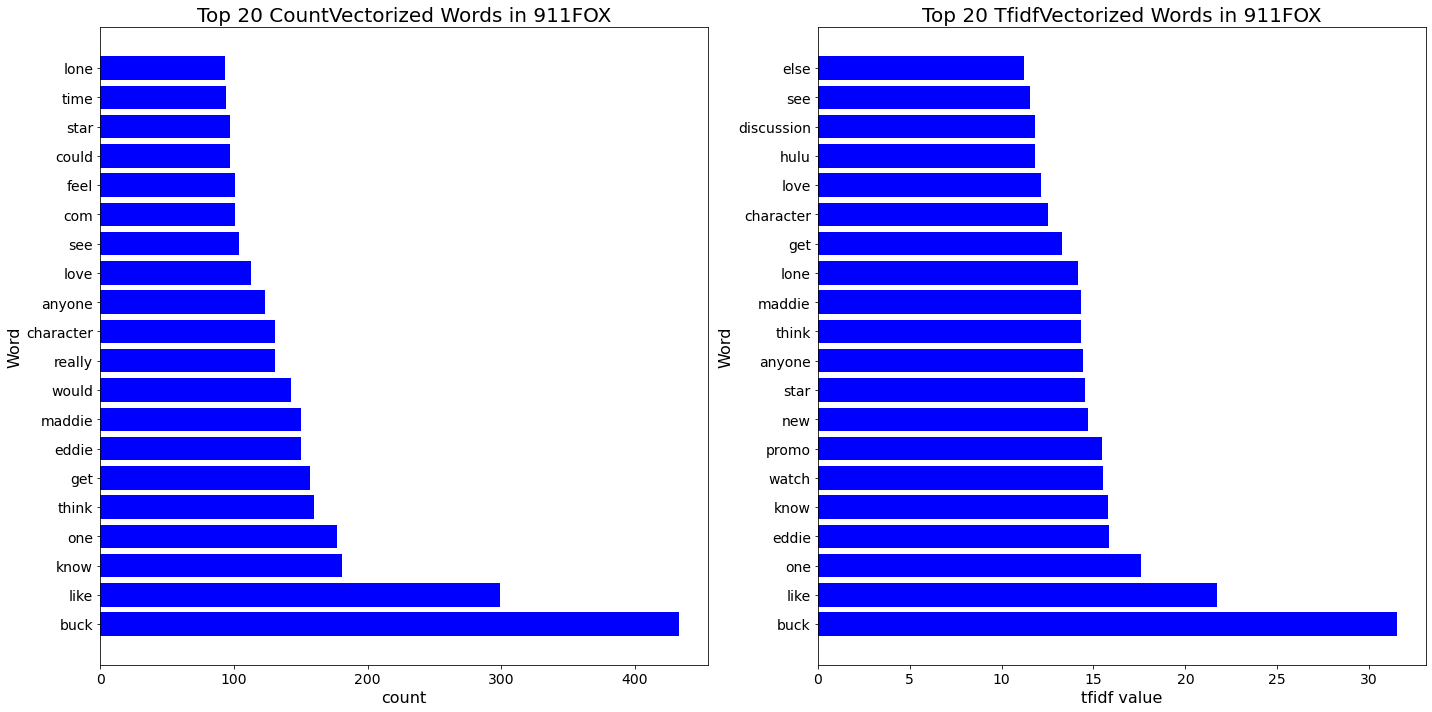

In [30]:
# Top 20 words from 'CountVectorizer' and 'TF-IDFVectorizer'

plot_graph(data[data['subreddit'] == '911FOX']['cleaned'],'911FOX')

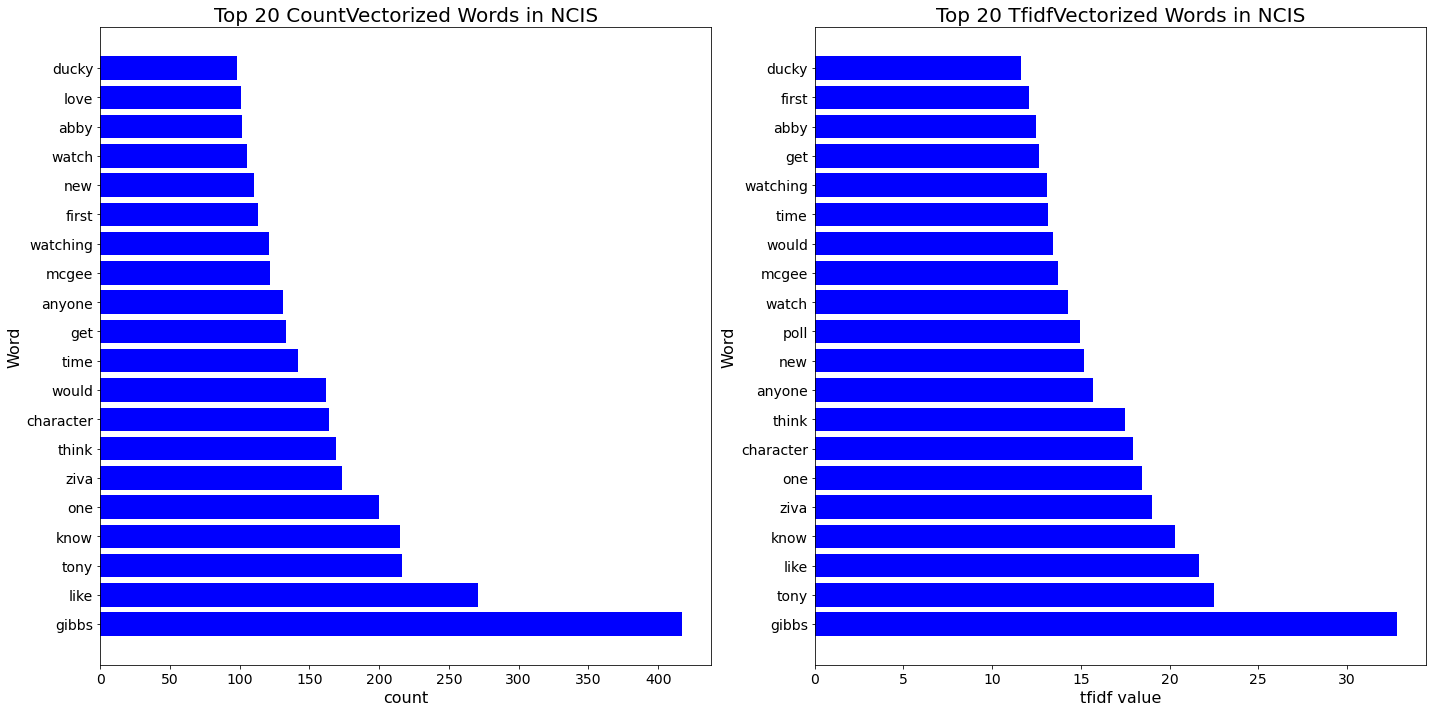

In [31]:
plot_graph(data[data['subreddit'] == 'NCIS']['cleaned'],'NCIS')

- The top 20 words from CountVectorizer and TF-IDF are quite similar.
- This means the type of vectorizer has a low impact on the model.
- From the charts, '911FOX' and 'NCIS' have general word such as like, one, character, and the character name is also the top word.

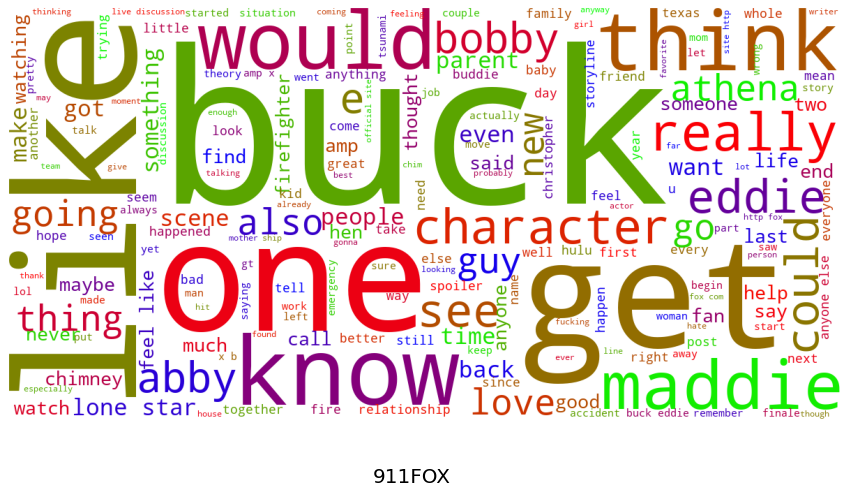

In [32]:
show_wordcloud(data[data['subreddit'] == '911FOX']['cleaned'],'911FOX')

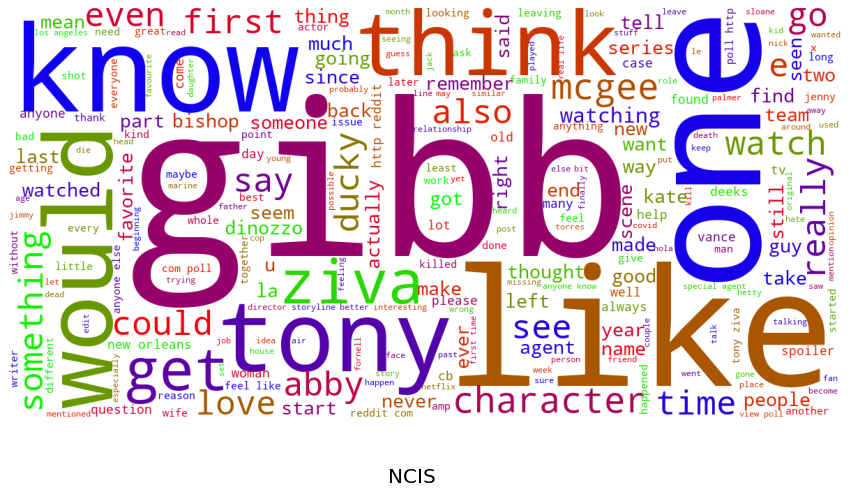

In [33]:
show_wordcloud(data[data['subreddit'] == 'NCIS']['cleaned'],'NCIS')

- From the word cloud, the result shows the word with the different size of the word. The biggest size shows the word count of that word is highest.
- The 911FOX's biggest word is 'buck' and the NCIS's biggest word is 'gibb'. Both words are the character name that manes people usually refer to these characters.

## Trian Test Split

In [34]:
# Change the subreddit into integer

data['subreddit'] = data['subreddit'].map({'NCIS':0, '911FOX':1})

In [35]:
data.head()

,cleaned,subreddit
0,airdate sunday january synopsis tragedy strike...,1
1,called tarmac flight attendant reach limit fli...,1
2,hey look familiar,1
3,six week break seems sooo long wondered anyone...,1
4,know fox airing begin hiatus except eddie fan ...,1


In [36]:
# Determine X and y

X = data[['cleaned']] # X is column of text named 'cleaned' from 'data'
y = data['subreddit'] # y is value from clumn named 'subreddit'

In [37]:
# Check the ratio between both subreddits

y.value_counts(normalize = True) 

# The data is not the unfair data

0    0.51902
1    0.48098
Name: subreddit, dtype: float64

In [38]:
# Split to create train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [39]:
X_train.shape

(1439, 1)

In [40]:
X_test.shape

(480, 1)

In [41]:
y_test.shape

(480,)

In [42]:
y_train.shape

(1439,)

After the setting train and test data, the test data size is 25% of all data.
- X_train has 1439 rows with 1 column.
- X_test has 480 rows with 1 column.
- y_train has 1439 rows.
- y_test has 480 rows.

## Model Preparation

- I create the pipeline and hyperparameter to be the model material.
- GridSearchCV is used to select the best estimator from the hyperparameter.

In [43]:
# Pipeline

# CountVectorizer and Logistic Regression
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
    
])

# CountVectorizer and Multinomial Naive Bayes
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
    
])

# TfidfVectorizer and Logistic Regression
pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
    
])

# TfidfVectorizer and Multinomial Naive Bayes
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
    
])

# CountVectorizer and Random Forest Classifier 
pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

# TfidfVectorizer and Random Forest Classifier 
pipe6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [44]:
# Hyperparameters

#CountVecterizer parameters
cvec_params = {'cvec__max_features': [2000, 3000, 4000, 5000],
              'cvec__min_df' : [2,3],
              'cvec__max_df' : [0.9, 0.95],
              'cvec__ngram_range' :[(1,1), (1,2)]}

# TfidfVectorizer parameters
tvec_params = {'tvec__max_features': [2000, 3000, 4000, 5000],
              'tvec__min_df' : [2,3],
              'tvec__max_df' : [0.9, 0.95],
              'tvec__ngram_range' :[(1,1), (1,2)]}

## Fit the model

- There has 6 models which have 2 types of transformation and 3 types of the classification model.
- All models are the overfitting model because the accuracy of training data is higher than the unseen data.
- The TF-IDF Vectorizer with Naive Bayes gives the best accuracy (87.5%) on unseen data so I choose this model to predict the post.

In [45]:
# Model

"""Logistic Regression & CountVectorizer"""
print('Logistic Regression & CountVectorizer')
gs1 = GridSearchCV(pipe1, param_grid = cvec_params,cv=5)
gs1.fit(X_train['cleaned'], y_train)
train_acc1 = gs1.best_estimator_.score(X_train['cleaned'], y_train)
test_acc1 = gs1.best_estimator_.score(X_test['cleaned'], y_test)
print(f'Accuracy on training data: {train_acc1}')
print(f'Accuracy on unseen data: {test_acc1}')
print('')

"""Naive Bayes & CountVectorizer"""
print('Naive Bayes & CountVectorizer')
gs2 = GridSearchCV(pipe2, param_grid = cvec_params,cv=5)
gs2.fit(X_train['cleaned'], y_train)
train_acc2 = gs2.best_estimator_.score(X_train['cleaned'], y_train)
test_acc2 = gs2.best_estimator_.score(X_test['cleaned'], y_test)
print(f'Accuracy on training data: {train_acc2}')
print(f'Accuracy on unseen data: {test_acc2}')
print('')

"""RandomForestClassifier & CountVectorizer"""
print('RandomForest & CountVectorizer')
gs5 = GridSearchCV(pipe5, param_grid = cvec_params, cv=5)
gs5.fit(X_train['cleaned'], y_train)
train_acc5 = gs5.best_estimator_.score(X_train['cleaned'], y_train)
test_acc5 = gs5.best_estimator_.score(X_test['cleaned'], y_test)
print(f'Accuracy on training data: {train_acc5}')
print(f'Accuracy on unseen data: {test_acc5}')
print('')

"""Logistic Regression & TF-IDF"""
print('Logistic Regression & TF-IDF')
gs3 = GridSearchCV(pipe3, param_grid = tvec_params,cv=5)
gs3.fit(X_train['cleaned'], y_train)
train_acc3 = gs3.best_estimator_.score(X_train['cleaned'], y_train)
test_acc3 = gs3.best_estimator_.score(X_test['cleaned'], y_test)
print(f'Accuracy on training data: {train_acc3}')
print(f'Accuracy on unseen data: {test_acc3}')
print('')

"""Naive Bayes & TF-IDF"""
print('Naive Bayes & TF-IDF')
gs4 = GridSearchCV(pipe4, param_grid = tvec_params,cv=5)
gs4.fit(X_train['cleaned'], y_train)
train_acc4 = gs4.best_estimator_.score(X_train['cleaned'], y_train)
test_acc4 = gs4.best_estimator_.score(X_test['cleaned'], y_test)
print(f'Accuracy on training data: {train_acc4}')
print(f'Accuracy on unseen data: {test_acc4}')
print('')


"""RandomForestClassifier & TF-IDF"""
print('RandomForest & CountVectorizer')
gs6 = GridSearchCV(pipe6, param_grid = tvec_params, cv=5)
gs6.fit(X_train['cleaned'], y_train)
train_acc6 = gs6.best_estimator_.score(X_train['cleaned'], y_train)
test_acc6 = gs6.best_estimator_.score(X_test['cleaned'], y_test)
print(f'Accuracy on training data: {train_acc6}')
print(f'Accuracy on unseen data: {test_acc6}')
print('')

Logistic Regression & CountVectorizer
Accuracy on training data: 0.9791521890201529
Accuracy on unseen data: 0.8479166666666667

Naive Bayes & CountVectorizer
Accuracy on training data: 0.9430159833217512
Accuracy on unseen data: 0.8666666666666667

RandomForest & CountVectorizer
Accuracy on training data: 0.9965253648366922
Accuracy on unseen data: 0.8729166666666667

Logistic Regression & TF-IDF
Accuracy on training data: 0.9701181375955524
Accuracy on unseen data: 0.86875

Naive Bayes & TF-IDF
Accuracy on training data: 0.9631688672689368
Accuracy on unseen data: 0.875

RandomForest & CountVectorizer
Accuracy on training data: 0.9965253648366922
Accuracy on unseen data: 0.8583333333333333



## Model Evaluation

### Confusion matrix

In [46]:
# Predict the result from X_test

y_preds = gs4.best_estimator_.predict(X_test['cleaned'])

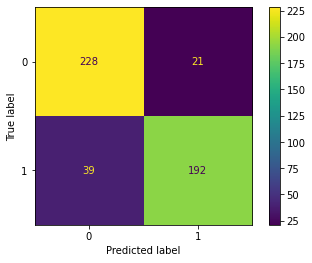

In [47]:
# Plot the confusion matrix

plot_confusion_matrix(gs4.best_estimator_, X_test['cleaned'], y_test)

In [48]:
confusion_matrix(y_test, y_preds)

array([[228,  21],
       [ 39, 192]])

In [49]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [50]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 228

False Positives: 21

False Negatives: 39

True Positives: 192


- True Negative means the subreddit is 'NCIS' and the model predicts 'NCIS'
- False Positive means the subreddit is 'NCIS' and the model predicts '911FOX'
- False Negative means the subreddit is '911FOX' and the model predicts 'NCIS'
- True Positive means the subreddit is '911FOX' and the model predicts '911FOX'

The false may come from the common word so I will try to look at the common word.

### Classification metrics 

In [51]:
accuracy = round(((tp+tn)/(tp+tn+fp+fn)),3)
missclassification = round(((fp+fn)/(tp+tn+fp+fn)),3)
sensitivity = round((tp/(tp+fn)),3)
specificity = round((tn/(tn+fp)),3)
precision = round((tp/(tp+fp)),3)

print(f'Accuracy is {accuracy}')
print(f'Misclassification rate is {missclassification}')
print(f'Sensitivity is {sensitivity}')
print(f'Specificity is {specificity}')
print(f'Precision is {precision}')

Accuracy is 0.875
Misclassification rate is 0.125
Sensitivity is 0.831
Specificity is 0.916
Precision is 0.901


- Accuracy: The model TF-IDF Vectorizer with Naive Bayes can predict correctly at 87.5%.
- Misclassification: The model TF-IDF Vectorizer with Naive Bayes gives the wrong prediction of about 12.5%.
- Sensitivity: About 83.1% that the model TF-IDF Vectorizer with Naive Bayes can predict True positives from all positives (real subreddit has 100% of 911FOX, the model can predict 83.1% of 911FOX)
- Specificity: About 91.6% that the model TF-IDF Vectorizer with Naive Bayes can predict True negatives from all negatives (real subreddit has 100% of NCIS, the model can predict 91.6% of NCIS)
- Precision: About 90.1% that the model predicts 911FOX and it is correct.

## Look for common words

- Misclassification is 12.5% and I think it might be because of the common word.
- I find the word that found in the 'y_test' and the result from prediction when the prediction result is not equal to 'y_test'.
- The 'word_text' column in 'data_test' is the text from X_test and the 'subreddit' is the number of subreddit for the text in each row.
- The 'data_test_sub' data frame comes from 'data_test', and it is added the new column named 'prediction' which comes from the result of the prediction. The 'data_test_sub' has 480 rows with 3 columns.

In [52]:
# Create the data_test dataframe

data_test = X_test

In [53]:
# data_test has 480 rows with 1 column

data_test.shape

(480, 1)

In [54]:
# Rename column

data_test = data_test.rename(columns = {'cleaned' : 'word_test'})

In [55]:
# Reset the index

data_test.reset_index(drop = True)

,word_test
0,hi started watching finale good people compair...
1,hello know might hate going tell abby annoying...
2,e anyone else see eddie wearing shoe boot
3,evan buck buckley mypuppy
4,pilot thread http redd nzjzn let go thread htt...
...,...
475,parallel life buck eddie obviously major chara...
476,killed marine learn human trafficking never le...
477,diane died
478,people like actually exist give hope case get ...


In [56]:
# Combine the 'data_test' with 'data' by pd.concat()

data_test_sub= pd.concat([data_test, data], axis = 1)

In [57]:
# Drop 'cleaned' column (this column comes with dataframe 'data')

data_test_sub.drop(columns = 'cleaned', inplace = True)

In [58]:
# Drop all missing values

data_test_sub.dropna(inplace = True)

In [59]:
data_test_sub.head()

,word_test,subreddit
0,airdate sunday january synopsis tragedy strike...,1
4,know fox airing begin hiatus except eddie fan ...,1
9,noticed quite episode paramedic back ambulance...,1
10,seen x far plz spoiler first season seemed lik...,1
12,rewatching got boy help maddie move meet assum...,1


In [60]:
data_test_sub.shape

(480, 2)

In [61]:
# Add the new column named 'prediction' into 'data_test_sub'

data_test_sub['prediction'] = gs4.best_estimator_.predict(data_test_sub['word_test'])

In [62]:
# Reset the index

data_test_sub.reset_index(drop = True, inplace = True)

In [63]:
data_test_sub.head()

,word_test,subreddit,prediction
0,airdate sunday january synopsis tragedy strike...,1,1
1,know fox airing begin hiatus except eddie fan ...,1,1
2,noticed quite episode paramedic back ambulance...,1,1
3,seen x far plz spoiler first season seemed lik...,1,0
4,rewatching got boy help maddie move meet assum...,1,1


- The 'data_test_sub' has 'subreddit' and 'prediction' columns.
- I use for-loop to select the text in which the prediction result is not equal to the real subreddit, and stored the text in the list named 'gentext'.
- The length of 'gentext' is 60 which is equal to the summation of False negative and False positive.
- All text in 'gentext' are converted into dataframe named 'gentext_df'.

In [64]:
# Extract the text

gentext = []
for index, value in data_test_sub.iterrows():
    if (value['subreddit']) != (value['prediction']):
        gentext.append(value['word_test'])

In [65]:
# number of text is 60

len(gentext)

60

In [66]:
# Create the dataframe

gentext_df = pd.DataFrame({'miss_classification_text':gentext})

In [67]:
gentext_df.head()

,miss_classification_text
0,seen x far plz spoiler first season seemed lik...
1,show currently watch think accurate use mask c...
2,know lot people die horribly rewatch pretty su...
3,one natural disaster big plot best view poll h...
4,comical need past episodeslooks like big time ...


In [68]:
gentext_df.shape

(60, 1)

In [69]:
# Check missing value

gentext_df.isnull().sum()

miss_classification_text    0
dtype: int64

- Create the for loop to present the number of the row that each word presents. 
- The word with a high number of row means it is usually found in the text that the model makes the wrong prediction.
- I select the top 5 words with have a high number of rows and remove them from the text.

In [70]:
# Set 'X_gen'

X_gen = gentext_df['miss_classification_text'] # X_gen is the 'miss_classification_text' from 'gentext_df'

In [71]:
# Count the number of row that the word presents

cvec = CountVectorizer()
cvec.fit(X_gen)
X_gen_cvec = cvec.transform(X_gen)
general_word_cvec = pd.DataFrame(X_gen_cvec.toarray(),
                              columns = cvec.get_feature_names())

# count the word
general_word_cvec_count = general_word_cvec.sum(axis = 0)
general_word_cvec_count =  general_word_cvec_count.sort_values(ascending = False)
for index, row in general_word_cvec_count.iteritems():
    print(index, row)

like 19
know 15
show 11
story 11
anyone 11
character 10
one 10
first 8
spoiler 8
episode 8
watching 8
feel 7
would 7
way 7
real 6
old 6
sometimes 6
question 6
get 5
watch 5
someone 5
people 5
bus 5
something 5
watched 5
going 5
got 5
ever 5
series 5
come 5
keep 5
could 4
seinfeld 4
mask 4
option 4
answer 4
accident 4
name 4
mean 4
else 4
last 4
guy 4
http 4
really 4
issue 4
crossover 4
say 4
poll 4
new 4
hit 4
look 4
phone 3
best 3
theme 3
big 3
better 3
even 3
synopsis 3
team 3
driver 3
abby 3
discussion 3
similar 3
said 3
seemed 3
seems 3
seen 3
com 3
server 3
shannon 3
shot 3
shown 3
change 3
post 3
song 3
think 3
sorry 3
sound 3
put 3
die 3
different 3
pretty 3
started 3
every 3
back 3
thinking 3
anything 3
tv 3
anybody 3
another 3
looking 3
much 3
ambulance 3
free 3
use 3
also 3
game 3
general 3
want 3
wanting 3
week 3
weird 3
well 3
went 3
jumped 3
happened 3
writing 3
horse 3
make 3
live 3
favourite 3
trivia 3
far 3
title 3
moment 3
time 3
mind 3
creator 2
resonance 2
needed 2
r

In [72]:
# 'general_word' is the index of 'general_word_cvec_count'

general_word = list(general_word_cvec_count.index)

In [73]:
# The top 5 common words

general_word[:5]

['like', 'know', 'show', 'story', 'anyone']

In [74]:
nltk.download('stopwords')
new_stopwords = ['episode', 'show', 'season', '911fox', '911', 'ncis', 'cis', 'http', 'www']
stop_words = (stopwords.words('english'))+(new_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fongnam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
# Combine the 'general_word' with the stop_words

general_and_stop_words = stop_words+ general_word[:5]

In [76]:
general_and_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [77]:
# Set the stop_words for TF-IDF as the all stopwords and common words

pipe8 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = general_and_stop_words)),
    ('nb', MultinomialNB())
    
])

In [78]:
# Model Naive Bayes & TF-IDF with the removing top 5 common words

"""Naive Bayes & TF-IDF"""
print('Naive Bayes & TF-IDF (remove common words)')
gs8 = GridSearchCV(pipe8, param_grid = tvec_params,cv=5)
gs8.fit(X_train['cleaned'], y_train)
train_acc8 = gs8.best_estimator_.score(X_train['cleaned'], y_train)
test_acc8 = gs8.best_estimator_.score(X_test['cleaned'], y_test)
print(f'Accuracy on training data: {train_acc8}')
print(f'Accuracy on testing data: {test_acc8}')
print('')

Naive Bayes & TF-IDF (remove common words)
Accuracy on training data: 0.9722029186935371
Accuracy on testing data: 0.8666666666666667



- The top 5 common words combined with the stop_words stored in a variable named 'general_and_stop_words', and will be used to be the stop_words in the next model.
- The accuracy of the model does not be improved. The accuracy of the model with the common word is 87.5%, but the removing common word decreases accuracy to 86.4%.
- I choose the model Naive Bayes & TF-IDF Vectorizer without the removing of common words.

## Finding the important word

- The best model in this work is the Naive Bayes & TF-IDF Vectorizer which has the best parameters from GridSearchCV following this.
    - TF-IDF: max_df = 0.9, max_features=3000, min_df=2
- The coefficient of each word is calculated by the function named 'show_most_informative_features'.
- The high coefficient means that word is the important word for the '911FOX' series's prediction.

In [79]:
gs4.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=3000, min_df=2)),
                ('nb', MultinomialNB())])

In [80]:
tvec = TfidfVectorizer(max_df=0.9, max_features=3000, min_df=2)
model = gs4.best_estimator_
model.fit(X_train['cleaned'], y_train)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=3000, min_df=2)),
                ('nb', MultinomialNB())])

In [81]:
def show_most_informative_features(data, vectorizer, clf, n=1000):
    transform = vectorizer.fit_transform(data)
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.named_steps['nb'].coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [82]:
show_most_informative_features(X_train['cleaned'], tvec, model)

	-8.5825	accepted       		-5.1725	buck           
	-8.5825	accidently     		-5.6173	like           
	-8.5825	accompanies    		-5.8541	one            
	-8.5825	accompli       		-5.8801	star           
	-8.5825	accused        		-5.8884	lone           
	-8.5825	advice         		-5.8998	maddie         
	-8.5825	aged           		-5.9597	eddie          
	-8.5825	agency         		-6.0233	watch          
	-8.5825	alexander      		-6.0553	hulu           
	-8.5825	alleyway       		-6.0826	anyone         
	-8.5825	allison        		-6.0911	discussion     
	-8.5825	alongside      		-6.0947	think          
	-8.5825	alpha          		-6.1078	know           
	-8.5825	alright        		-6.1429	promo          
	-8.5825	amirite        		-6.1451	new            
	-8.5825	analogy        		-6.1545	get            
	-8.5825	angry          		-6.1792	fox            
	-8.5825	anthony        		-6.1860	else           
	-8.5825	apparent       		-6.1863	bobby          
	-8.5825	appear         		-6.2272	love           


	-8.3931	insta          		-8.0366	action         
	-8.3927	lashing        		-8.0375	flashback      
	-8.3927	toddler        		-8.0391	light          
	-8.3923	dumb           		-8.0402	three          
	-8.3921	physically     		-8.0403	award          
	-8.3907	risk           		-8.0415	father         
	-8.3906	sell           		-8.0423	pandemic       
	-8.3905	lab            		-8.0432	filler         
	-8.3904	bro            		-8.0435	wear           
	-8.3904	granted        		-8.0435	built          
	-8.3904	talked         		-8.0436	bizarre        
	-8.3899	decide         		-8.0439	severe         
	-8.3898	mode           		-8.0440	viewer         
	-8.3897	launch         		-8.0448	nearly         
	-8.3897	virus          		-8.0452	det            
	-8.3897	involving      		-8.0454	room           
	-8.3895	arc            		-8.0455	gave           
	-8.3891	fanfiction     		-8.0463	reminds        
	-8.3886	sat            		-8.0466	graduation     
	-8.3885	worked         		-8.0467	among          


On the left-hand side, the words with a low coefficient (-8.5825) are the words that have low relevant to the 911FOX post while the words and coefficient on the right-hand side are the important words for 911FOX prediction.

## Predict the subreddit when user make a post

This is the model to predict the unseen post from the user. The input in this model is the title and selftext of a post and it will answer which subreddit that the post should be sent to.

In [83]:
# model to predic the new post
lemmatizer = WordNetLemmatizer()
title = input('please enter your title: ')
selftext = input('please enter your text: ')
text = title + selftext
print('')

# pre-processing
new_text = re.sub('[^A-Za-z]+', r' ', text) # Remove non-letter
splited = new_text.lower().split() # Convert to the lower letter
no_stw = [w for w in splited if w not in stop_words] # Remove stopwords
lemma = [lemmatizer.lemmatize(w) for w in no_stw] # Lemmatizer
string = (" ".join(lemma)) # Join string
series = pd.Series(string) # Make string to be series

# Prediction
prediction = gs4.best_estimator_.predict(series)
if prediction == [1]:
    print('911FOX')
else:
    print('NCIS')

please enter your title: Buck 911
please enter your text: I love Buck because he is the main character 

911FOX


## Conclusions and Recommendations

**Model and Word Evaluation**


The best model in this work is the model by Naive Bayes with TF-IDF Transformation. This model has the highest efficiency at 87.5% on unseen data. This model has a misclassification of about 12.5%. Therefore, I improved the model by common word removal but the accuracy does not be improved and it decreases to 86.4%. For this reason, I selected the model without the common word removal and analyse the important word for prediction.

In this work, I assumed '911FOX' as 1 and 'NCIS' as 0 and the result of the coefficient shows the influence of each word on 911FOX prediction. The result of the important word with the coefficient is shown in the following table 1. The top 10 words have 3 character names (buck, maddie, eddie) and 2 words the name of season (lone, star) and 1 word of movie website (hulu). The top words show the popular characters are 'Buck', 'Maddie' and 'Eddie' and the popular season is 911: Lone Star, and the popular platform the user post on 911FOX Reddit is the Hulu website. 

Table 1: The top 10 words that will help to increase the correct prediction on 9-1-1.

|No.|Subreddit|Word|Coefficient|
|---|---|---|---|
|1.|**911FOX**|*buck*|-5.1725|
|2.|**911FOX**|*like*|-5.6173|
|3.|**911FOX**|*one*|-5.8541|
|4.|**911FOX**|*star*|-5.8801|
|5.|**911FOX**|*lone*|-5.8884|
|6.|**911FOX**|*maddie*|-5.8998|
|7.|**911FOX**|*eddie*|-5.9597|
|8.|**911FOX**|*watch*|-6.0233|
|9.|**911FOX**|*hulu*|-6.0553|
|10.|**911FOX**|*anyone*|-6.0826|


**Business Recommendation**

- The model can help to increase the accuracy of the post in 911FOX and NCIS subreddits, and encourage Reddit to create a new searching system. When we have the model to predict the subreddit for each post, Reddit can improve the searching system to receive the input from the user as the specific word and recommend the relevant subreddit. This will make the user post easier because some users do not know the name of the subreddit.
- The subreddit with the most accuracy of the post checking and show only the relevant post will increase the satisfaction of the user.
- When Reddit has more accuracy of the post in each subreddit, they can make the business deal with another website. In this case, we know the 911FOX has the post about Hulu and the Hulu is the top 10 words which have high coefficient so Reddit can make a deal with the Hulu website to increase the value of Reddit and the number of users.


**Next step of the future work**
- The model from this work can improve the classification between r/911fox and r/ncis but it has some misclassification. So, Reddit should have the word recommendation when the user post on Reddit to prevent misspelling and increase the quality of data when the text from the user inputs to the model. 
- Since the common word removal cannot develop the model, so the next step should be the setting the hyperparameter for all regression model (logistic regression, Naive Bays and RandonForest Classifier) to get the best parameter.